# FastAI Transfer Learning

This approach is based on using the fastai libray, copying techniques used in Lesson1 of the fast.ai course 
- https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson1-pets.ipynb

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
import numpy as np

In [3]:
import warnings; warnings.simplefilter('ignore')
np.random.seed(2)

### Enable GPU
https://stackoverflow.com/questions/48152674/how-to-check-if-pytorch-is-using-the-gpu

In [4]:
import torch
torch.cuda.is_available(), torch.cuda.get_device_name(torch.cuda.current_device()), 

(True, 'GeForce GTX 1060')

In [5]:
torch.cuda.current_device()

0

In [6]:
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]
print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

GPU RAM Free: 5742MB | Used: 336MB | Util   6% | Total 6078MB


# Import Data

csv2png.js converts the CSV file into a ImageNet style diretory tree of images
which can be loaded into an ImageDataBunch for use with fastai

In [7]:
data = ImageDataBunch.from_folder('./data/images/', 
                                  test='test',
                                  valid_pct=0.2,
                                  #ds_tfms=get_transforms(do_flip=False),
                                 )\
                     .normalize(imagenet_stats)

In [8]:
data

ImageDataBunch;

Train: LabelList (33600 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
0,0,0,0,0
Path: data/images;

Valid: LabelList (8400 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
4,0,1,1,5
Path: data/images;

Test: LabelList (28000 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: EmptyLabelList
,,,,
Path: data/images

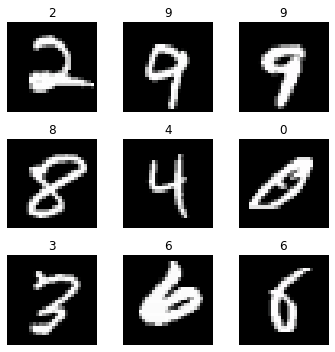

In [9]:
data.show_batch(rows=3, figsize=(5,5))

## Establish Baseline: resnet18

Lets start with the smallest network on the list and get some baseline results
- CPU Timings: 02:50 per epoc @ bs=64
- GPU Timings: 01:30 per epoc @ bs=64   (2x improvement) 
- GPU Timings: 01:10 per epoc @ bs=512 
- GPU Timings: 01:10 per epoc @ bs=1024 
- GPU Timings: 01:10 per epoc @ bs=2048 (but lower accuracy) 

In [10]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
# learn.model = learn.model.cpu()   # throws exception
# learn.model = learn.model.cuda()  # is this line required? no effect on speed
learn.fit(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.565763,0.374060,0.882500,00:11
1,0.324611,0.236726,0.926667,00:11


In [11]:
learn.save('resnet18');

In [12]:
def write_csv_predictions(csv_file, learn):
    predictions, *_ = learn.get_preds(DatasetType.Test)
    labels        = np.argmax(predictions, 1)
    submission_df = pd.DataFrame({'ImageId': list(range(1,len(labels)+1)), 'Label': labels})
    submission_df.to_csv(csv_file, index=False)

In [13]:
write_csv_predictions('./submissions/fastai/fastai-resnet18-fit2.csv', learn)

In [14]:
predictions, *_ = learn.get_preds(DatasetType.Test); predictions

tensor([[4.0928e-05, 7.4335e-06, 3.6102e-09,  ..., 2.3859e-10, 8.9958e-11,
         4.3644e-10],
        [4.4017e-05, 1.4781e-04, 9.7218e-01,  ..., 5.1609e-04, 5.7148e-03,
         2.8615e-04],
        [4.0115e-03, 1.7241e-04, 1.8618e-03,  ..., 5.8185e-05, 5.2201e-03,
         6.1761e-05],
        ...,
        [2.7523e-04, 1.0756e-04, 6.2876e-03,  ..., 1.1793e-03, 9.6107e-01,
         5.0023e-03],
        [3.2782e-07, 1.1057e-08, 7.7257e-08,  ..., 5.1339e-11, 2.3030e-05,
         1.6168e-08],
        [2.4337e-04, 1.4689e-04, 9.9147e-01,  ..., 7.3122e-04, 3.9458e-03,
         1.8889e-03]])

In [15]:
labels          = np.argmax(predictions, 1); labels

tensor([6, 2, 6,  ..., 8, 6, 2])

In [16]:
open_image('data/images/test/00003.png')

In [17]:
learn.predict(open_image('data/images/test/00003.png'))

(Category 9,
 tensor(9),
 tensor([1.2445e-03, 3.0042e-05, 8.7725e-03, 4.2844e-03, 6.9309e-04, 1.6898e-03,
         2.5671e-03, 6.4782e-04, 9.6482e-02, 8.8359e-01]))

### Submit to Kaggle
```
kaggle competitions submit -c digit-recognizer -f ./submissions/fastai-resnet18-fit2.csv -m "fastai: resnet18 + fit(2)"
```

Score: 0.09371 | Rank: 2509/2521

This establishes a baseline score we can attempt to beat

### Add More Epocs

In [18]:
learn.fit(8)
learn.save('resnet18');

epoch,train_loss,valid_loss,accuracy,time
0,0.250808,0.152968,0.952857,00:11
1,0.193561,0.120666,0.962619,00:11
2,0.150489,0.108273,0.967857,00:11
3,0.133849,0.096999,0.972143,00:12
4,0.131463,0.081705,0.976071,00:11
5,0.106326,0.081247,0.974048,00:11
6,0.101876,0.073263,0.977024,00:11
7,0.084125,0.075969,0.976548,00:11


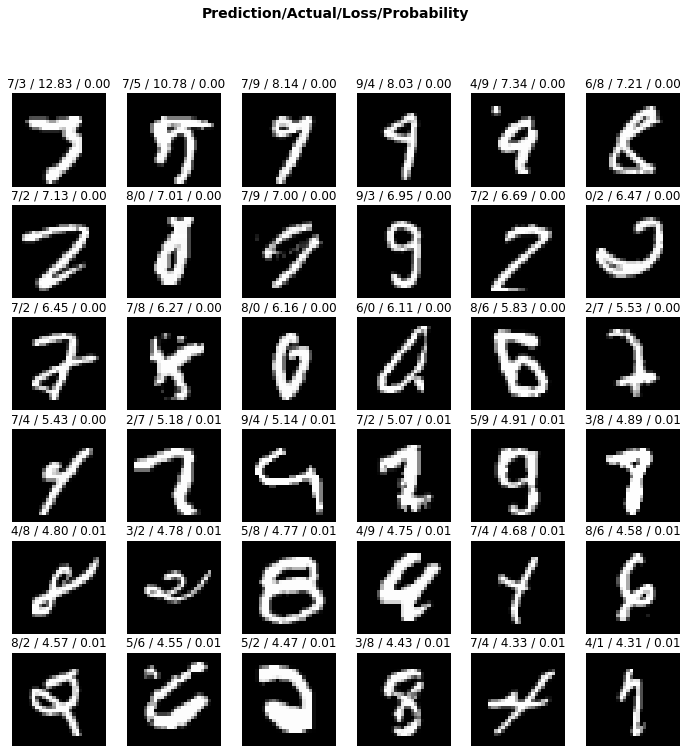

In [19]:
learn.interpret().plot_top_losses(36)

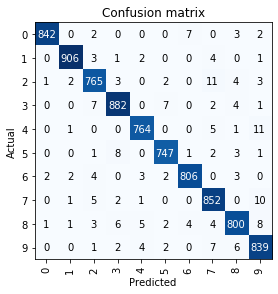

In [20]:
learn.interpret().plot_confusion_matrix()

In [21]:
write_csv_predictions('./submissions/fastai/fastai-resnet18-fit10.csv', learn)

##### Submit To Kaggle
```
kaggle competitions submit -c digit-recognizer -f ./submissions/fastai-resnet18-fit10.csv -m "fastai: resnet18 + fit(10)"
```
- Score: 0.09614 | Rank: 2517/2529 | ./submissions/fastai-resnet18-fit10.csv

### Learning Rate Finding

We can use learning rate finding and fit_one_cycle to achieve superconvergence if we want to see how far we get resnet18 to converge
https://docs.fast.ai/callbacks.one_cycle.html#What-is-1cycle?

In [22]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


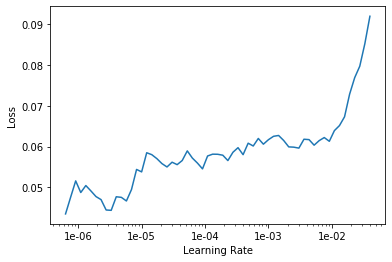

In [23]:
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(20, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.071056,0.077015,0.976429,00:11
1,0.076080,0.073892,0.977024,00:11
2,0.070243,0.071063,0.978333,00:11
3,0.071585,0.069602,0.978810,00:11
4,0.060488,0.067572,0.979405,00:11
5,0.061776,0.068568,0.979762,00:11
6,0.061629,0.067419,0.979881,00:12
7,0.057640,0.066858,0.980357,00:11
8,0.051081,0.066176,0.981548,00:12
9,0.059520,0.067005,0.980595,00:11


In [25]:
learn.save('resnet18-30');
write_csv_predictions('./submissions/fastai/fastai-resnet18-fit_one_cycle_30.csv', learn)

##### Submit To Kaggle
```
kaggle competitions submit -c digit-recognizer -f ./submissions/fastai-resnet18-fit_one_cycle_30.csv -m "fastai: resnet18 + fit_one_cycle(30, 1e-2)"
```
- Score: 0.09614 | Rank: 2517/2529 | ./submissions/fastai-resnet18-fit_one_cycle_30.csv

# Pretrained Neural Networks

There are several other pretrained models to choose from: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

In [26]:
# dir(models)
model_names = [
 'alexnet',
 'darknet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'squeezenet1_0',
 'squeezenet1_1',
 'unet',
 'vgg11_bn',
 'vgg13_bn',
 'vgg16_bn',
 'vgg19_bn',
 'wrn',
 'wrn_22',
 'xception',
 'xresnet',
 'xresnet101',
 'xresnet152',
 'xresnet18',
 'xresnet34',
 'xresnet50'
]
errors = ['alexnet', 'darknet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'unet', 'vgg11_bn', 'vgg13_bn', 'vgg16_bn', 'vgg19_bn', 'wrn', 'wrn_22', 'xception', 'xresnet', 'xresnet101', 'xresnet152', 'xresnet18', 'xresnet34', 'xresnet50']
learns = {}

In [27]:
for name in model_names:
    if name in learns.keys(): continue
    if name in errors:        continue
    try:
        print( name )
        model = getattr(models, name)
        learns[name] = cnn_learner(data, model, metrics=accuracy)
        learns[name].lr_find()
    except:
        print( "error: ", name )
        errors.append(name)
        
print( "errors", errors )

resnet101


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
resnet152


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
resnet18


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
resnet34


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/jamie/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
resnet50


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/jamie/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
squeezenet1_0


Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /home/jamie/.cache/torch/checkpoints/squeezenet1_0-a815701f.pth


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
squeezenet1_1


Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /home/jamie/.cache/torch/checkpoints/squeezenet1_1-f364aa15.pth


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
errors ['alexnet', 'darknet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'unet', 'vgg11_bn', 'vgg13_bn', 'vgg16_bn', 'vgg19_bn', 'wrn', 'wrn_22', 'xception', 'xresnet', 'xresnet101', 'xresnet152', 'xresnet18', 'xresnet34', 'xresnet50']


resnet101
resnet152
resnet18
resnet34
resnet50
squeezenet1_0
squeezenet1_1


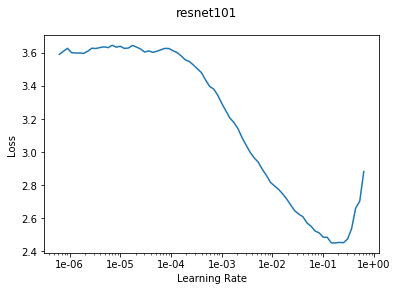

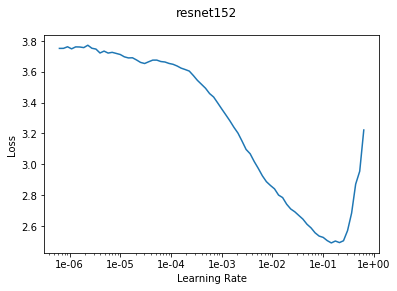

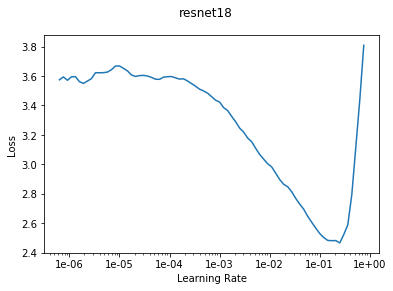

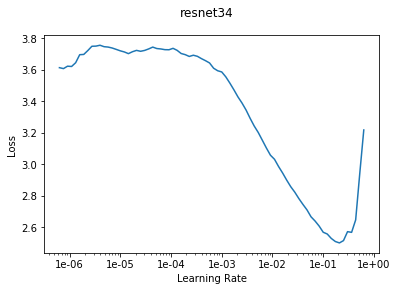

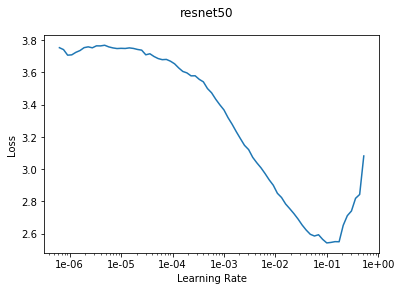

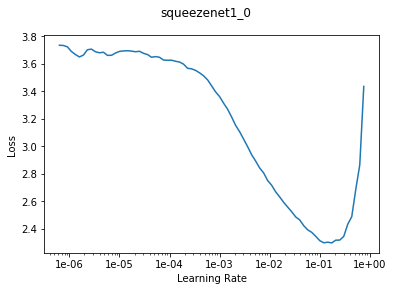

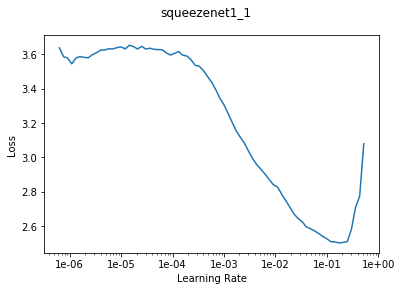

In [28]:
for name in model_names:
    if name in errors: continue
    print( name )        
    learns[name].recorder.plot(return_fig=True).suptitle(name)

It appears that 1e-01 seems to be an suitable max learning rate for all of the above

In [ ]:
for name in model_names:
    if name in errors: continue
    print( name )        
    learns[name].fit_one_cycle(10, slice(1e-3,1e-1))
    #learns[name].save(f'{name}-10');
    write_csv_predictions(f'./submissions/fastai/fastai-{name}-10.csv', learns[name])    

resnet101


epoch,train_loss,valid_loss,accuracy,time
0,0.453082,0.296087,0.918214,00:46
1,0.749860,0.595251,0.940714,00:46
2,1.198206,1.532905,0.928571,00:47
3,1.047603,0.524311,0.973571,01:02
4,0.650577,0.798797,0.975000,00:55
5,0.566200,0.416382,0.981905,00:47
6,0.293413,0.407258,0.971548,00:45
7,0.097185,0.110470,0.987500,00:46
8,0.045671,0.059065,0.990714,00:46
9,0.025635,0.048252,0.992024,00:46


resnet152


epoch,train_loss,valid_loss,accuracy,time
0,0.384884,0.257180,0.928690,01:07
1,0.888186,0.460150,0.960476,01:08
2,1.457154,1.040111,0.949167,01:07
3,0.921434,0.848144,0.972381,01:07


In [ ]:
for name in model_names:
    if name in errors: continue
    print( name )       
    learns[name].unfreeze()
    learns[name].fit_one_cycle(30, slice(1e-3,1e-1))
    #learns[name].save(f'{name}-40');
    write_csv_predictions(f'./submissions/fastai/fastai-{name}-40.csv', learns[name])    

In [ ]:
# for name in model_names:
#     if name in errors: continue
#     print( name ) 
#     learns[name].unfreeze()    
#     learns[name].fit_one_cycle(60, slice(1e-3,1e-1))
#     learns[name].save(f'{name}-100');
#     write_csv_predictions(f'./submissions/fastai/fastai-{name}-100.csv', learns[name])        